# Small Sample Regression with K-Fold Cross-Validation

This simple linear regression predicts salary as a function of years of experience.  It uses the "salary\_data of Employees with years of Experience" dataset by <a href="https://www.kaggle.com/harsh45" target="blank_">Harsh singh</a> and can be found <a href="https://www.kaggle.com/harsh45/random-salary-data-of-employes-age-wise" target="blank_">here</a>.

This small dataset only has 30 samples, so setting aside even a single random sample could have an impact on the line of best fit.  In searching for resampling methods, I came across k-fold cross-validation and decided it would be a good method to try.

## Intro to k-fold Cross-Validation

K-fold cross-validation divides the dataset into <i>k</i> equal segments called folds.  When the cross-validation function is run, <i>k-1</i> folds are used as training data, and the remaining fold is used as test data.  This process is repeated until each fold has been used as test data.  The cross-validation scores are averaged to obtain an overall model accuracy percentage, or $R^2$.

*Note: Technically a few data points should be removed from the initial set to act as a final validation set that has never been seen by the model.  I didn't realize that until I was pretty much done, so I just decided to do that next time. :)*

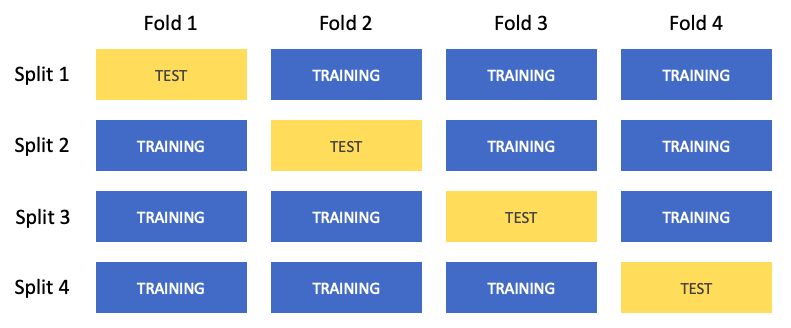

## Step 1. Hypothesize the Model
This is pretty straightforward.  There are only two variables, so this will be a simple linear regression with the response variable being **Salary** and the predictor variable being **Years of Experience**.

Here is the hypothesized model: \\( y=\beta_{0}+\beta_{1}x+\epsilon \\)

## Step 2. Collect the Data

Here are the various packages installed for this exercise, as well as the first 5 rows of the `Salary_Data` dataframe:

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn import linear_model # Needed for Linear Regression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold # K-fold Cross-Validation
from sklearn.model_selection import cross_val_score # Cross-Validation Score
from sklearn.metrics import r2_score # R-Squared
from scipy.stats import pearsonr

In [ ]:
Salary_Data = pd.read_csv("../input/random-salary-data-of-employes-age-wise/Salary_Data.csv")
Salary_Data.head()

## Two Ways to Calculate Model Accuracy with k-fold

I hunted around for a while before finding any useful k-fold tutorials.  Most of them are very simple, just splitting a single array of `range(0,9)` to show how the function works, but it isn't very helpful without any real context around it.  Eventually I found two sites that were very helpful.  They showed a couple different ways to set up the k-fold.  Both work for determining the $R^2$ value, but, as you'll see below, I was able to use the second method for calculating much more than overall model accuracy.

These are the two sites I found most helpful:

- <a href="https://financetrain.com/k-fold-cross-validation-example-python-scikit-learn/" target="_blank">FinanceTrain.com: K-Fold Cross Validation Example Using Python scikit-learn</a>
- <a href="https://www.pluralsight.com/guides/validating-machine-learning-models-scikit-learn" target="_blank">Pluralsight.com: Validating Machine Learning Models with scikit-learn</a>

In both methods, the independent variable is created as a Pandas DataFrame, and the dependent variable is a Series.  I thought that was confusing.  It seemed like they should both work as Series.  I was mistaken!  As you'll see in the second method below, the independent variable is iterated over using `iloc`, which requires a DataFrame instead of a Series.  Thank you to my colleague <a href="https://www.linkedin.com/in/morgan-gladden-12ba41144/" target="_blank">Morgan Gladden</a> for clearing that up for me!

You'll also notice the same k-fold parameters in both methods.  There are 5 splits, meaning the 30 data points will be split into 5 folds of 6 items each.  The `shuffle` parameter is set to `True` because the original dataset is arranged in ascending order, and the `random_state` is set to 1 for repeatability.

*Note: The `random_state` of 1 actually returned the lowest $R^2$ value of state values 0-3.  I decided to keep it because it was the first number I chose, and I didn't want my pride to get in the way of the reality that sometimes random choice is a bummer ¯\\\_(ツ)\_/¯*

### Method 1: $R^2$ Only

The first method has 5 main steps:
1. Create the independent and dependent variables.
1. Set the k-fold parameters mentioned above.
1. Create the linear regression model
1. Create the variable `results_kfold` to store the cross-validation scores for each split, incorporating the `kfold` variable into the `cv` parameter.
1. Obtain the $R^2$ by taking the mean of the cross-validation scores from the regression.

In [ ]:
x1 = Salary_Data.drop('Salary', axis=1).values # Maintain the dataframe by dropping the Salary column
y1 = Salary_Data['Salary'].values              # Create a Pandas Series as the target variable.

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

slr = linear_model.LinearRegression()

results_kfold = cross_val_score(slr, x1, y1, cv=kfold) # Stores the accuracy of each split in a Numpy array.

print("R\N{SUPERSCRIPT TWO}: %.2f%%" % (results_kfold.mean()*100.0))

### Method 2: Using a For loop to store lots of cool things!
The first steps here are pretty much the same as Method 1.

In [ ]:
X = Salary_Data[['YearsExperience']]  # Note the double square brackets.  This must be a DataFrame.
y = Salary_Data.Salary

slr = linear_model.LinearRegression() # Create the linear regression model

kf = KFold(n_splits=5, shuffle=True, random_state=1) # Set the k-fold parameters
kf.split(X)

You can see here that in Method 2 I used a For loop to store several different values from the split iterations.  The most important for the rest of this analysis is the `residuals` list, which you will see used a few more times in validating assumptions about the model.

The output below looks a little cluttered, but I wanted to print out the different splits so you can see how each fold uses different indexes (indices?) for the validation set.

In [ ]:
accuracy_model = []  # The average of this list is the overall R-Squared
slope = []
intercept = []
residuals = []       # These will be used to validate model assumptions

for train_index, test_index in kf.split(X):
    print('Train: %s\nTest: %s\n' % (train_index, test_index))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = slr.fit(X_train, y_train)
    r2 = r2_score(y_test, model.predict(X_test))
    accuracy_model.append(r2)
    slope.append(slr.coef_)
    intercept.append(slr.intercept_)
    residuals.append(y_test-model.predict(X_test))

## Step 3. Estimate Parameters
Let's take a look at the estimated parameters.  The thing that surprised me most was the $R^2$ value.  I expected it to be much higher.  The bar chart below explains why: one of the splits happened to generate a validation fold that was not very accurate.

In [ ]:
# This is the cross-validation score (aka the overall accuracy of the model)
# round((sum(accuracy_model)/len(accuracy_model))*100,2)
print("Average R\N{SUPERSCRIPT TWO}: %.2f%%" % ((sum(accuracy_model)/len(accuracy_model))*100))

In [ ]:
plt.bar(range(1,6),accuracy_model)
plt.title("R\N{SUPERSCRIPT TWO} Values by Split")
plt.xlabel("Split")
plt.ylabel("R\N{SUPERSCRIPT TWO} as a Decimal")
caption="Random sampling led to Split 1 having a very low R\N{SUPERSCRIPT TWO} value"
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=12, color="gray")

Let's see what the values are for \\( \beta_{1} \\) and \\( \beta_{0} \\):

In [ ]:
print('\u03B2\N{SUBSCRIPT ONE}: %.2f' % ((sum(slope)/len(slope))))
print('\u03B2\N{SUBSCRIPT ZERO}: %.2f' % ((sum(intercept)/len(intercept))))

Lastly, we need to make sure the relationship between the predictor and response variables is significant with Pearson's r:

In [ ]:
corr_coeff = pearsonr(Salary_Data.YearsExperience, Salary_Data.Salary)
print('Pearson r= %.3f' % corr_coeff[0])
print('p-value= ' + str(corr_coeff[1]))

Looks like they are highly correlated, with a correlation coefficient of 0.978 and a p-value of 1.143e-20.  In this test, the null hypothesis ($H_0$) is that there is no correlation between the two variables.  This significantly small p-value shows that there is no reasonable chance that we would see this strong of a correlation if the null hypothesis were true.  Reject that $H_0$!  Woohoo!

## Step 4. Check Assumptions

### Assumptions 1 & 2: Mean of Error = 0, Variance of Error is constant
As you can see below, the mean of the residuals is 125.54.  That is definitely not zero, but where we are looking at numbers in the 50,000 - 100,000 range, I'm not too bothered by it.

You can see in the residuals plot below that there is a pretty good spread across all X values.  It's worth noting that there seem to be more negative values than positive values, but the largest residuals are positive.

In [ ]:
print("The mean of the residuals is %.2f" % np.mean(residuals))

In [ ]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    fold_residuals = y_test-model.predict(X_test)
    plt.scatter(y_test.index, fold_residuals, color='#1f77b4')
#     plt.scatter(y_test.index, fold_residuals)
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.title("Residuals Plot")
    plt.axhline(0, color="#d62728")

**Side Note:** I discovered that by default, residuals are plotted by color according to fold (see below!).  It reminds me of Skittles, and I was sorely tempted to keep it, but I decided too many colors might be distracting, so I stuck with the conservative default blue. :)

In [ ]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    fold_residuals = y_test-model.predict(X_test)
#     plt.scatter(y_test.index, fold_residuals, color='#1f77b4') # This line makes all the dots blue
    plt.scatter(y_test.index, fold_residuals) # This line colors the dots according to their assigned test fold
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.title("Residuals Plot")
    plt.axhline(0, color="#d62728")

#### Predicted vs. Actual Plot

I'd say this fit looks okay, but certainly not excellent.  There are a few more points above the line at lower salary levels and a few more points below the line at higher salary levels, meaning \\( \beta_{0} \\) is a bit low and \\( \beta_{1} \\) is a little too steep.

In [ ]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    plt.scatter(y_test, slr.predict(X_test), color='#1f77b4')
#     plt.scatter(y_test, slr.predict(X_test))
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title("Actual vs. Predicted Salaries")
y_lim = plt.ylim()
x_lim = plt.xlim()
plt.plot(x_lim, y_lim, 'k-', color ="#d62728")
plt.ylim(y_lim)
plt.xlim(x_lim)

### Assumption 3: Error is Normally distributed
The residuals histogram for this regression doesn't look totally normal to me, but the Shapiro-Wilk test below returned a p-value of 0.186, so I failed to reject the null hypothesis.  Thanks to Machine Learning Mastery for the <a href="https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/" target="_blank">Shapiro-Wilk code and tutorial!</a>

In [ ]:
combined_residuals = pd.concat([residuals[0], residuals[1], residuals[2], residuals[3], residuals[4]], ignore_index=True)
plt.hist(combined_residuals, bins=7)
plt.title("Residuals Distribution")
plt.ylabel("Frequency")
plt.xlabel("Residual Amount")

In [ ]:
from scipy.stats import shapiro

resid_sum = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    fold_residuals = y_test-model.predict(X_test)
    resid_sum.append(fold_residuals)

all_residuals = pd.concat([resid_sum[0],resid_sum[1],resid_sum[2],resid_sum[3],resid_sum[4]])

# Thanks to Machine Learning Mastery for the Shapiro-Wilk code and tutorial!
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

stat, p = shapiro(all_residuals)
print('Test Statistic=%.3f, p-value=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Distribution of residuals looks Normal (fail to reject H0)')
else:
    print('Distribution of residuals does not look Normal (reject H0)')

### Assumption 4: Errors are independent of one another

Last, but not least, there is no indiciation that the salaries and years of experience in this data set are related to one another.  Absent any further information, they are assumed to be independent of one another.

## Reflection
I learned a lot more from this project than I was expecting!  I actually created the first draft several weeks ago as a very quick practice of simple linear regression and left it alone for a while.  I came back to it because I wanted to update it to use a random seed to create repeatable results while still being able to shuffle the dataset.  I tried to import `random`, but that only works on Lists.

On top of that, I was only pulling out a single data point for validation, so I started searching for other techniques.  That's when I came across resampling and cross-validation techniques, and suddenly  there was a new world of possibilities! :)

As I noted at the top, if I were to go back and do this again, I would probably pull out three data points from the initial dataset and use them as a final validation set.  Next time!

I'm also getting much more comfortable with different Python data types, Matplotlib, Markdown, and LaTeX.